# 1D1V PIC Code 


### From: A. Marocchino, 2014 
Link: https://github.com/ALaDyn/pyPICu

Isa: 

- Want to work up to 1D3V
- Using an electrostatic, non-relativistic plasma 
- Code here uses periodic boundaries
    - will eventually want to implement an RF-driven system 
- Focus: 
    - writing readable code 
    - adding theory/commentary/figures where possible 
    - speed up the process!
- Upload to Git!

### Importing Libraries

In [1206]:
import math
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt 
import time
%matplotlib inline

### Depositing charge (electrons) 

Isa: 

- Create figure to illustrate this point

In [1207]:
start = time.clock() # Keeping track of computational time 

def charge_dep(pos, J, dx): 
    """Takes position, number of gridpoints, and grid spacing as arguments"""
    """Generates weights used to determine particle trajectory"""
    
    weights = np.zeros((J,1))
    
    for i in range(0, len(pos)):
        v = np.floor(pos[i]/dx)
        weights[int(v)] += 1. - (pos[i] / (dx-v))
        weights[int(v)+1] +=  (pos[i] / (dx-v))
        
    weights[0] += weights[-1] #Periodic boundary conditions 
    
    return weights[0:J-1]

print("Clocking in at %s seconds"  % (time.clock() - start))

Clocking in at 0.00030500000138999894 seconds


### Calculating the Electric Field 

Isa: 

- Which scheme is best? (finite difference or element?)
- Add the theory for both, elaborate on the one used

In [1208]:
start = time.clock() # Keeping track of computational time 

def E_from_V(rho, J, dx):
    """Uses the finite difference scheme"""
    
    source = rho[0:J-1]*dx**2
    M = np.zeros((J-1,J-1))
    
    for i in range(0, J-1):
        for j in range(0, J-1):
            if i == j: 
                M[i,j] = 2.
            if i == j-1:
                M[i,j] = -1.
            if i == j+1: 
                M[i,j] = -1.
                
    M[0, J-2] = -1.
    M[J-2, 0] = -1.
        
    V = np.linalg.solve(M, source)
        
    E = np.zeros((J,1))
    
    for i in range (1,J-2): 
        E[i] = (V[i+1] - V[i-1]) / 2./dx
    E[J-2] = (V[0] - V[J-3]) / 2./dx
    E[0] = (V[1] - V[J-2]) / 2./dx
    E[J-1] = E[0]
    E = -E
            
    return E


print("Clocking in at %s seconds"  % (time.clock() - start))

Clocking in at 0.0010929999989457428 seconds


### Velocity pusher 

Need stuff on this

In [1209]:
start = time.clock() 


def v_push(p_pos, p_velo, E, dx, dt): 
    for i in range(0, len(p_velo)):
        v = np.floor(p_pos[i]/dx)
        w1 = 1 - (p_pos[i]/dx-v)
        w2 = 1 - w1
        p_velo[i] += QM * (w1 * E[int(v)] + w2 * E[int(v) + 1]) * dt
    
    return p_velo

print("Clocking in at %s seconds"  % (time.clock() - start))

Clocking in at 0.00045200000022305176 seconds


### Particle pusher

Need stuff on this too 

In [1210]:
start = time.clock() 

def p_push(p_pos, p_velo, dt, L):
    for i in range(0, len(p_pos)):

        p_pos[i] += p_velo[i] * dt

        if p_pos[i] >= L: 
            p_pos[i] -= L 

        if p_pos[i] < 0: 
            p_pos[i] += L 

    return p_pos
    
print("Clocking in at %s seconds"  % (time.clock() - start))


Clocking in at 0.00036700000055134296 seconds


### Inputs 

[Describe the problem here]

In [1211]:
J = 2000 #number of grid cells 1000 seems to produce the best results
L = 6 #physical lenght of the system

dx = L/(J-1)
dt = 0.1 

N = 20000

v0 = 0.4
vth_0 = 1

xp1 = 0.1 
vp1 = 0

iterations = 3000

wp = 1 
QM = -1 

mode = 1

Q = wp**2/(QM*(N/L))

rho_back = -Q*(N/L)

### Initialize

In [1212]:
start = time.clock() 

p_pos = np.linspace(0, L, N+1)[0:-1]
p_velo = vth_0 * np.random.standard_normal((N))
p_velo[range(0,N-1,2)] = v0
p_velo[range(1,N,2)] = -v0
p_velo = np.divide( (p_velo+vp1*np.sin(2.*np.pi*p_pos/L*mode) ), ( 1.+p_velo*vp1*np.sin(2.*np.pi*p_pos/L*mode)) )

for i in range(0,N):
    p_pos[i] += xp1*(L/N)*np.sin(2.*np.pi*p_pos[i]/L*mode);
    if p_pos[i] >= L:
        p_pos[i] -= L
    if p_pos[i] < 0:
            p_pos[i] += L
            
print("Clocking in at %s seconds"  % (time.clock() - start))

Clocking in at 0.11209700000472367 seconds


### Main cycle 

Isa: 

- It takes ~ 7s to run 10 iterations. This means that for a standard number of iterations (~2000), the main cycle will take nearly an hour to run! How can we make this a more efficient process? 

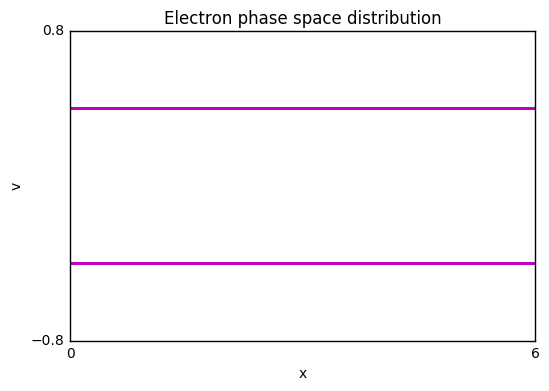

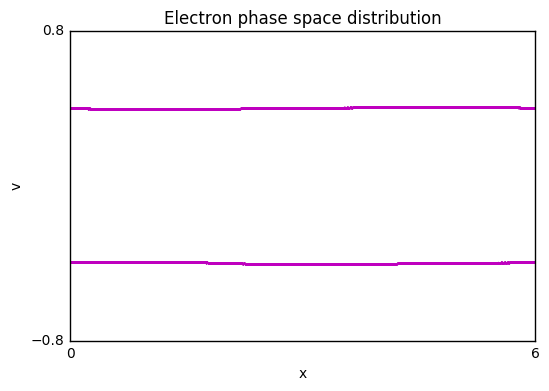

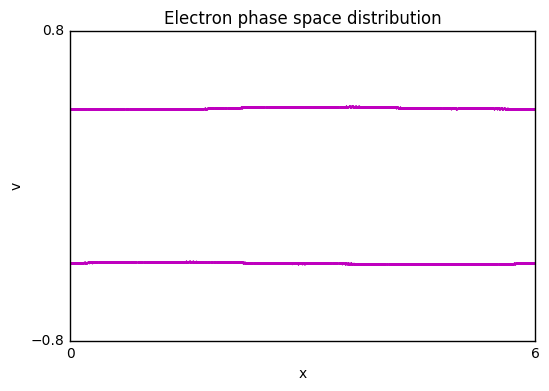

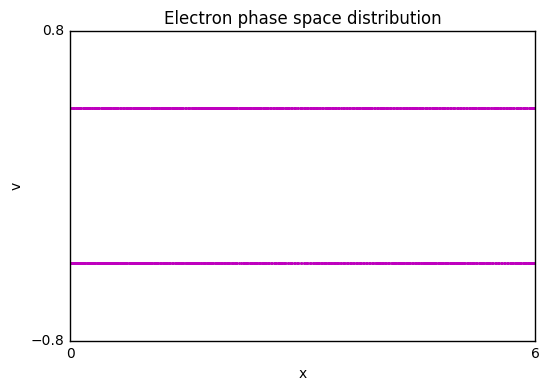

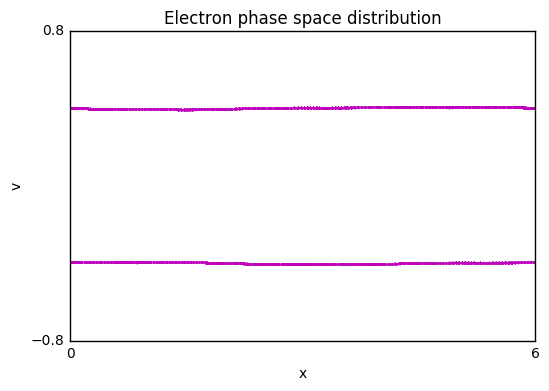

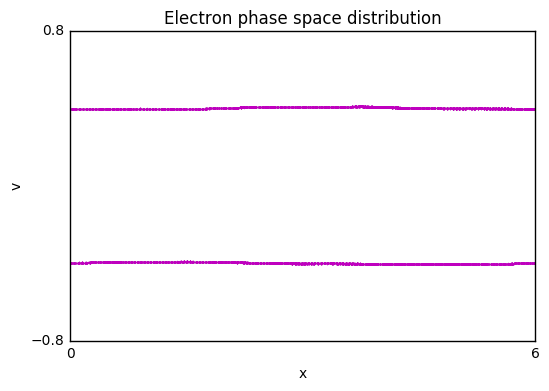

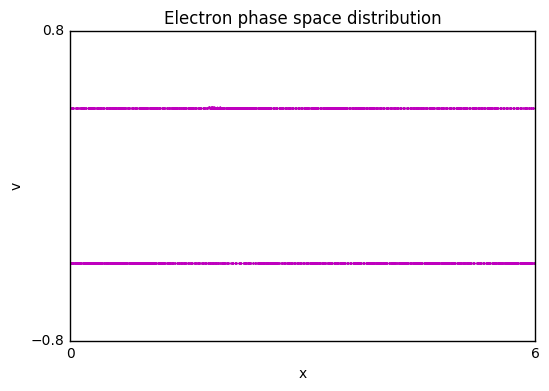

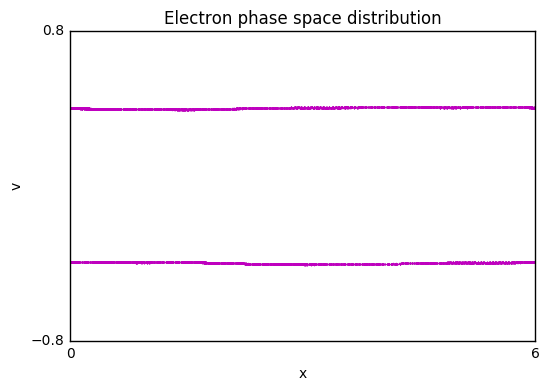

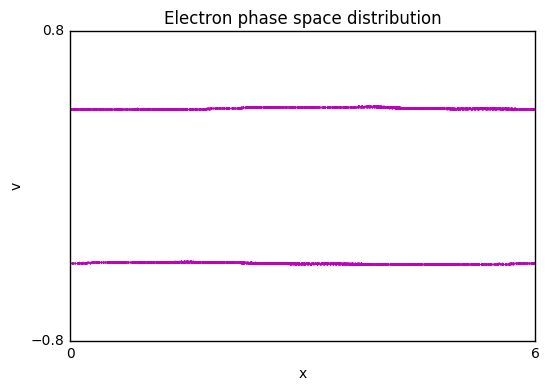

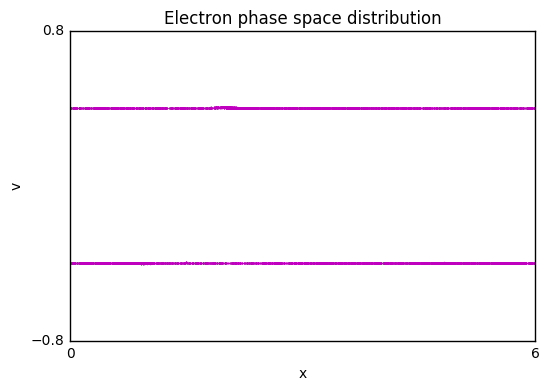

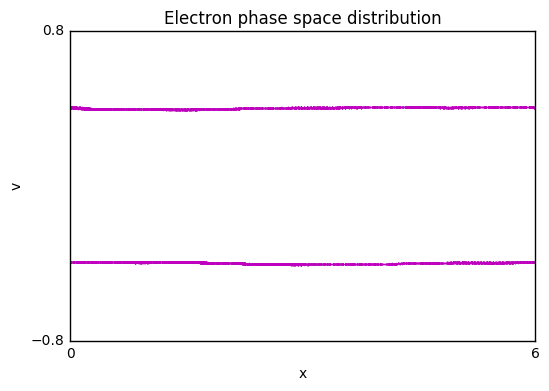

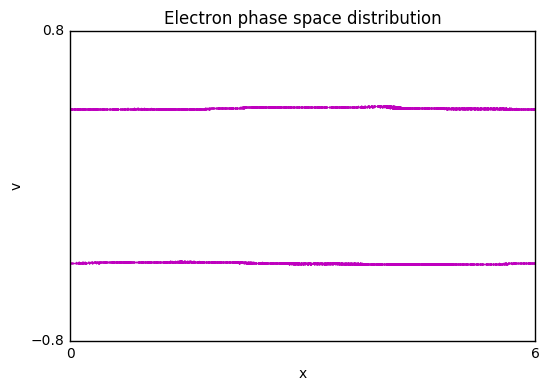

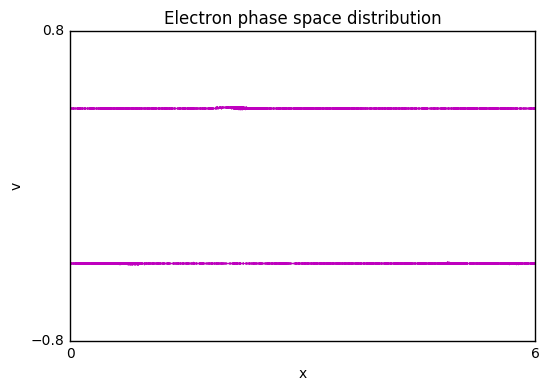

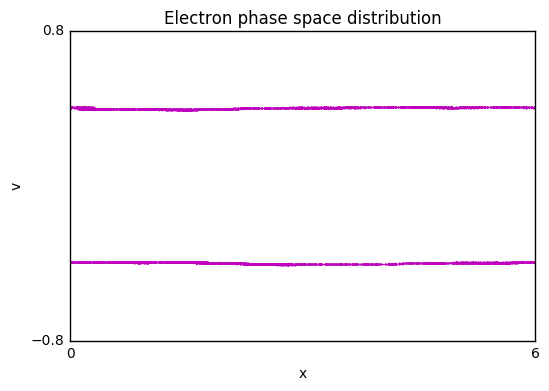

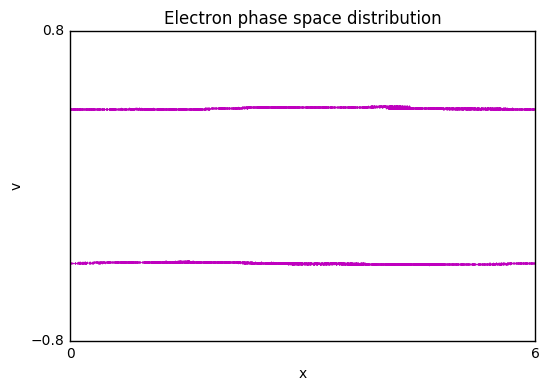

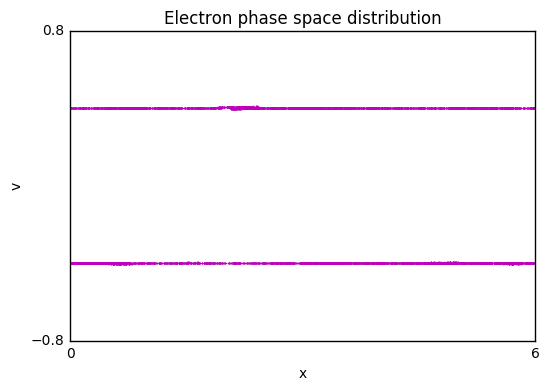

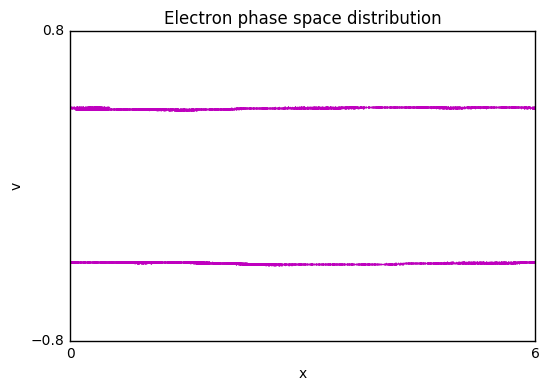

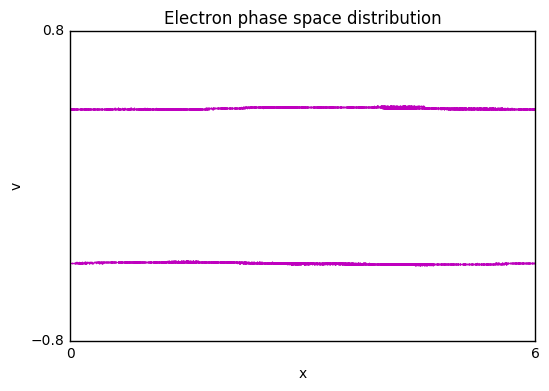

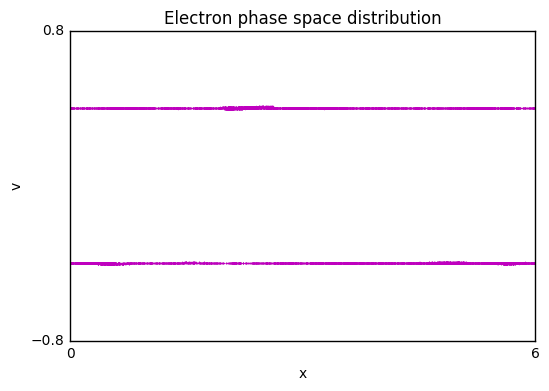

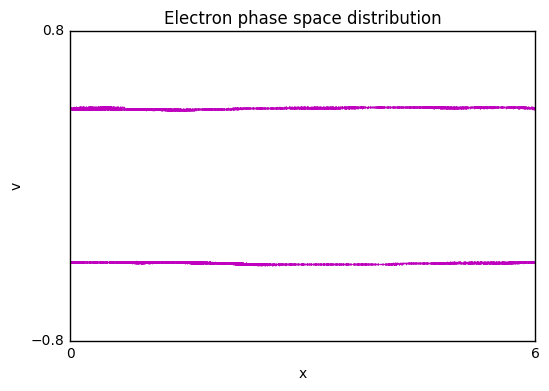

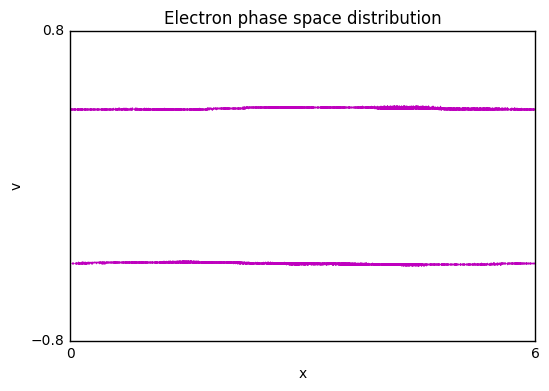

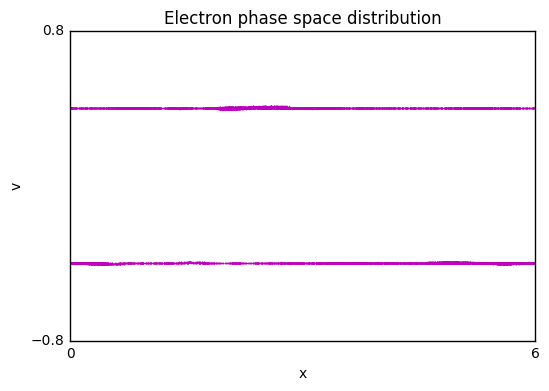

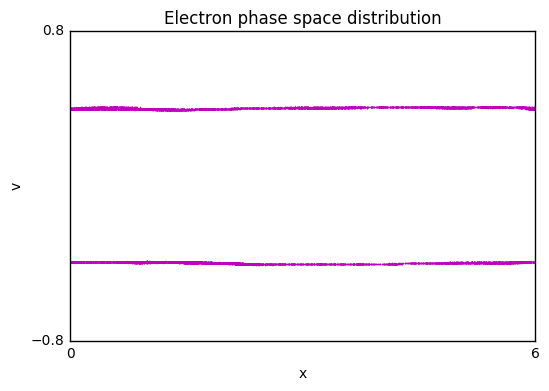

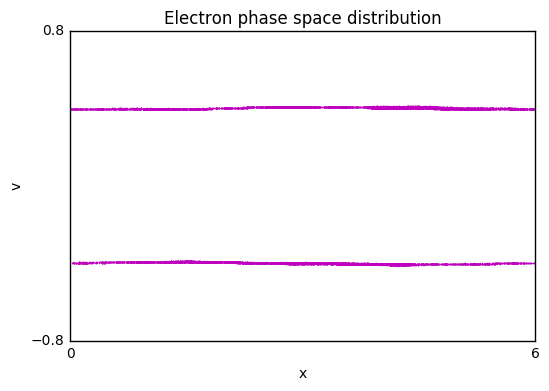

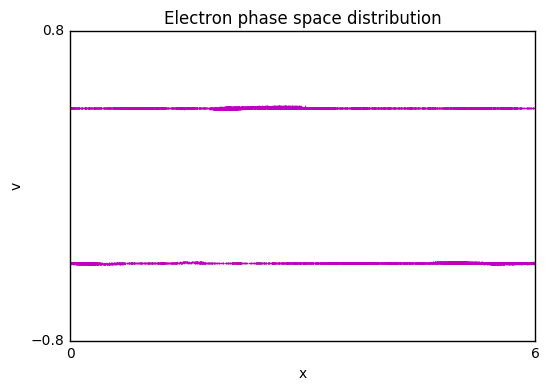

KeyboardInterrupt: 

In [1213]:
start = time.clock()

for count in range(0, iterations):
    
    rho = charge_dep(p_pos, J, dx)
    rho = Q/(dx * rho + rho_back)
        
    E = E_from_V(rho, J, dx)
    
    p_pos = p_push(p_pos, p_velo, dt , L)
    p_velo = v_push(p_pos, p_velo, E, dx, dt)
    #p_pos = (p_pos, p_velo, dt , L)
    
    #print(len(p_velo), len(p_pos))
        
    #if count%10 == 0: 
    #    print(count)
        
    if count%100 == 0 or count == iterations:
        fig = plt.figure(1, figsize=(6.0,4.0))
        plt.plot(p_pos,p_velo,'m.', ms=1.1)
        plt.title('Electron phase space distribution')
        plt.xticks([0, L])
        plt.xlabel('x')
        plt.yticks([-2*v0, 2*v0])
        plt.ylabel('v')

        plt.show()
        
        #fig = plt.figure(1, figsize=(8,12))
        #fig, axes = plt.subplots(nrows=3, ncols=1)
        #plt.tight_layout()
        #
        #ax1 = plt.plot() #was plt.subplot(311)
        #ax1.plot(p_pos,p_velo,'m.', ms=1.1)
        #ax1.set_title('Phase space')
        #ax1.set_xticks([])
        #ax1.set_ylim([2*-v0, 2*v0])
        #ax1.set_yticks([2*-v0, 0, 2*v0])
        #ax1.plot()
        
        #ax2 = plt.subplot(312)
        #ax2.plot(np.linspace(0,L,len(rho)),np.append(rho[0:-1],rho[0]),'k')
        #ax2.set_title('Charge density')
        #ax2.set_xticks([])
        #ax2.set_yticks([])
        #
        #ax3 = plt.subplot(313)
        #ax3.plot(np.linspace(0, L, len(E)), E, 'k')
        #ax3.set_title('Electric field')
        #ax3.set_xticks([0, L])
        #ax3.set_yticks([])
        
        plt.show()

    
    
print("Clocking in at %s seconds"  % (time.clock() - start))

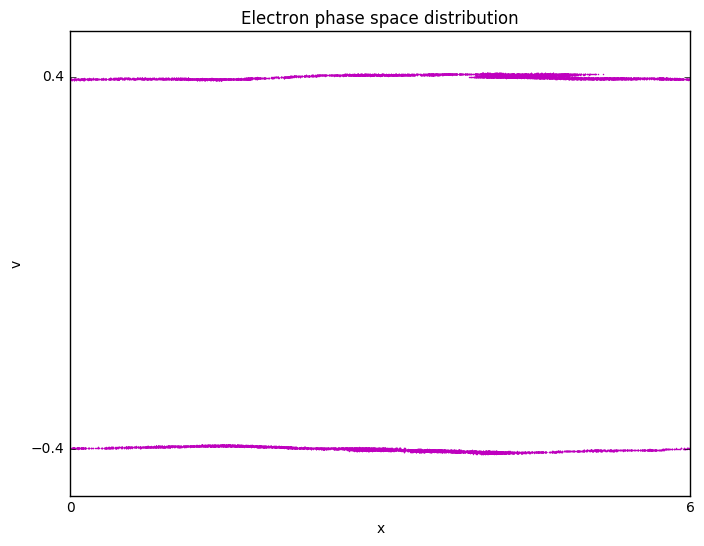

In [1214]:
fig = plt.figure(1, figsize=(8.0,6.0))
plt.plot(p_pos,p_velo,'m.', ms=1.1)
plt.title('Electron phase space distribution')
plt.xticks([0, L])
plt.xlabel('x')
plt.yticks([-v0, v0])
plt.ylabel('v')

plt.show()

### Misc. code testing

In [1215]:
#p = np.linspace(0,10,5)
#d = 0.06
#w = np.zeros((4,1))
#
#for i in range (0,len(p)):
#    pp = np.floor(p[i]/ d)
#    m = (p[i]/(dx-pp))
#    w = 1. - m
#    wp = 1- w
#    
#print(p,int(pp),m, w, wp)
#

#r=Q/(dx*rho+rho_back)
#print(len(r))

#source = -rho[1:J-1]*dx**2
#print(len(source))

#count?

 